In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn import tree
import seaborn as sns

from sklearn.preprocessing import scale, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier

# Load the data 

In [4]:
def load(x,y,z,c,v): 
    df_x = pd.read_csv(x)
    df_y = pd.read_csv(y)
    df_z = pd.read_csv(z)
    df_c = pd.read_csv(c)
    df_v = pd.read_csv(v)
    return df_x, df_y, df_z, df_c, df_v


def cleanup(df_x, df_y, df_z, df_c, df_v):
    df_x = df_x[["pid","study_yr"]]
    df_y = df_y[["race","gender","age","scr_res0","scr_res1","scr_res2","pid"]]
    df_z = df_z[["sct_ab_desc","sct_ab_num","study_yr","pid"]]
    df_c = df_c.drop(columns=["visible_days","dataset_version"])
    df_v = df_v[["pid","de_stag","lesionsize","lc_morph","lc_behav","lc_grade","study_yr","lc_order"]]
    return df_x, df_y, df_z, df_c, df_v


def data(df_x, df_y, df_z, df_c, df_v):
    
    df_c[["sct_ab_attn","sct_ab_gwth"]] = df_c[["sct_ab_attn","sct_ab_gwth"]].fillna(9)
    df_c["sct_ab_invg"] = df_c["sct_ab_invg"].fillna(1)
    df_c.dropna(axis = 0, how="any", inplace= True )
    def update(row):
        if pd.isna(row["lesionsize"]):
            if row["de_stag"]<310:
                return 1
            elif row["de_stag"]>=310:
                return 25
            return row["lesionsize"]
        else:
            return row["lesionsize"]



    df_v["lesionsize"] = df_v.apply(update,axis = 1)
    df_v.dropna(axis = 0, how="any", inplace= True )

    return df_x, df_y, df_z, df_c, df_v


def merge(df_x, df_y, df_z, df_c, df_v):
    df_c = df_c.rename(columns={"sct_ab_code":"sct_ab_desc"})
    df = df_y.merge(df_x,on = "pid", how = "outer").merge(df_z, on =["pid","study_yr"],how = "outer").merge(df_c,on =["pid","study_yr","sct_ab_desc"],how = "outer").merge(df_v, on="pid", how = "outer")
    df = df.drop(columns=["sct_ab_num_y","study_yr_y"])
    df[["study_yr_x","sct_ab_desc","sct_ab_num_x","de_stag","lesionsize","lc_morph","lc_behav","lc_grade","lc_order"]] = df[["study_yr_x","sct_ab_desc","sct_ab_num_x","de_stag","lesionsize","lc_morph","lc_behav","lc_grade","lc_order"]].fillna(0)
    df[["sct_ab_preexist", "sct_ab_attn", "sct_ab_gwth", "sct_ab_invg"]] = df[["sct_ab_preexist", "sct_ab_attn", "sct_ab_gwth", "sct_ab_invg"]].fillna(1)
    df = df.dropna()
    
    return df


In [5]:
df_x, df_y, df_z, df_c, df_v = load("nlst_780_screen_idc_20210527.csv","nlst_780_prsn_idc_20210527.csv","nlst_780_ctab_idc_20210527.csv","nlst_780_ctabc_idc_20210527.csv","nlst_780_canc_idc_20210527.csv")
df_x, df_y, df_z, df_c, df_v=cleanup(df_x, df_y, df_z, df_c, df_v)
df_x, df_y, df_z, df_c, df_v=data(df_x, df_y, df_z, df_c, df_v)                                
df = merge(df_x, df_y, df_z, df_c, df_v)

In [6]:
# going to remove all the patients without cancer
df = df.loc[df["de_stag"] != 0]

In [8]:
# I have to turn the target column "de_stag" into integers. It is currently in type float
df["de_stag"] = df["de_stag"].astype(int)

In [10]:
# XGboost model requires the target value to be from [0-10] values instead of the current values that I have in the target column. 
# Will do a .map to change the values from the current version to the required ones. Will have to change the key again at the end or make a new one to know what each refers to. 
key = {110:0 , 120:1 , 210:2 , 220:3 , 310:4 , 320:5 , 400:6 , 888:7 , 900:8 , 994:9 , 999:10}
df["de_stag"] = df["de_stag"].map(key)

# XGboost model

In [16]:
X = df.drop("de_stag",axis = 1)
y = df["de_stag"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [18]:
xgbmodel = XGBClassifier()

In [20]:
xgbmodel.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [22]:
# I will define specific values for the parameters to fit my goal
params={"objective": ["multi:softprob"],
        "n_estimators": [2000],
        "max_depth": [8,10,12],
        "learning_rate":[0.05,0.1],
        "subsample": [0.7],
        "colsample_bylevel": [0.8,1],
        "colsample_bynode": [0.8,1],
        "colsample_bytree": [0.8,1],
        "gamma": [0.2],
        "verbosity": [2],
        "min_child_weight": [1],
        "n_jobs": [6]}


In [24]:
n_cv = 2 # train test split
xgbmodel = XGBClassifier() #model that I will be using


# scoring: Techniques I will use to objectify the findings
scoring = ['roc_auc', 'accuracy']



# Create a gridsearch with the scoring, parameters and model.
grid_solver = GridSearchCV(estimator = xgbmodel, # model to train
                           param_grid = params, # param_grid
                           scoring = scoring,
                           cv = n_cv,
                           refit = 'accuracy',
                           verbose = 2)

In [26]:
grid_solver.fit(X_train,y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)])

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[0]	validation_0-mlogloss:2.26574	validation_1-mlogloss:2.26996
[1]	validation_0-mlogloss:2.15562	validation_1-mlogloss:2.16514
[2]	validation_0-mlogloss:2.05519	validation_1-mlogloss:2.06939
[3]	validation_0-mlogloss:1.97252	validation_1-mlogloss:1.99038
[4]	validation_0-mlogloss:1.89222	validation_1-mlogloss:1.91365
[5]	validation_0-mlogloss:1.81937	validation_1-mlogloss:1.84460
[6]	validation_0-mlogloss:1.75031	validation_1-mlogloss:1.77887
[7]	validation_0-mlogloss:1.68955	validation_1-mlogloss:1.72177
[8]	validation_0-mlogloss:1.63538	validation_1-mlogloss:1.67094
[9]	validation_0-mlogloss:1.58743	validation_1-mlogloss:1.62495
[10]	validation_0-mlogloss:1.53730	validation_1-mlogloss:1.57728
[11]	validation_0-mlogloss:1.48756	validation_1-mlogloss:1.53021
[12]	validation_0-mlogloss:1.43919	validation_1-mlogloss:1.48442
[13]	validation_0-mlogloss:1.39590	validation_1-mlogloss:1.44380
[14]	validation_0-mlogloss:1.35445	vali

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[22]	validation_0-mlogloss:1.08905	validation_1-mlogloss:1.15537
[23]	validation_0-mlogloss:1.06258	validation_1-mlogloss:1.13035
[24]	validation_0-mlogloss:1.03921	validation_1-mlogloss:1.10810
[25]	validation_0-mlogloss:1.01605	validation_1-mlogloss:1.08602
[26]	validation_0-mlogloss:0.99261	validation_1-mlogloss:1.06359
[27]	validation_0-mlogloss:0.97156	validation_1-mlogloss:1.04333
[28]	validation_0-mlogloss:0.95099	validation_1-mlogloss:1.02401
[29]	validation_0-mlogloss:0.93141	validation_1-mlogloss:1.00588
[30]	validation_0-mlogloss:0.91301	validation_1-mlogloss:0.98867
[31]	validation_0-mlogloss:0.89586	validation_1-mlogloss:0.97239
[32]	validation_0-mlogloss:0.87876	validation_1-mlogloss:0.95630
[33]	validation_0-mlogloss:0.86136	validation_1-mlogloss:0.93982
[34]	validation_0-mlogloss:0.84510	validation_1-mlogloss:0.92441
[35]	validation_0-mlogloss:0.82874	validation_1-mlogloss:0.90910
[36]	validation_0-mlogloss:0.81402	validation_1-mlogloss:0.89528
[37]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[20]	validation_0-mlogloss:1.07154	validation_1-mlogloss:1.13729
[21]	validation_0-mlogloss:1.04314	validation_1-mlogloss:1.11087
[22]	validation_0-mlogloss:1.01504	validation_1-mlogloss:1.08374
[23]	validation_0-mlogloss:0.98906	validation_1-mlogloss:1.05906
[24]	validation_0-mlogloss:0.96349	validation_1-mlogloss:1.03443
[25]	validation_0-mlogloss:0.93885	validation_1-mlogloss:1.01132
[26]	validation_0-mlogloss:0.91510	validation_1-mlogloss:0.98863
[27]	validation_0-mlogloss:0.89226	validation_1-mlogloss:0.96669
[28]	validation_0-mlogloss:0.87088	validation_1-mlogloss:0.94656
[29]	validation_0-mlogloss:0.85044	validation_1-mlogloss:0.92726
[30]	validation_0-mlogloss:0.83003	validation_1-mlogloss:0.90767
[31]	validation_0-mlogloss:0.81089	validation_1-mlogloss:0.88948
[32]	validation_0-mlogloss:0.79256	validation_1-mlogloss:0.87207
[33]	validation_0-mlogloss:0.77375	validation_1-mlogloss:0.85446
[34]	validation_0-mlogloss:0.75766	validation_1-mlogloss:0.83984
[35]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[17]	validation_0-mlogloss:1.17668	validation_1-mlogloss:1.24111
[18]	validation_0-mlogloss:1.14391	validation_1-mlogloss:1.21066
[19]	validation_0-mlogloss:1.11077	validation_1-mlogloss:1.17899
[20]	validation_0-mlogloss:1.07795	validation_1-mlogloss:1.14855
[21]	validation_0-mlogloss:1.04953	validation_1-mlogloss:1.12183
[22]	validation_0-mlogloss:1.02047	validation_1-mlogloss:1.09399
[23]	validation_0-mlogloss:0.99394	validation_1-mlogloss:1.06888
[24]	validation_0-mlogloss:0.96733	validation_1-mlogloss:1.04368
[25]	validation_0-mlogloss:0.94169	validation_1-mlogloss:1.01949
[26]	validation_0-mlogloss:0.91814	validation_1-mlogloss:0.99790
[27]	validation_0-mlogloss:0.89419	validation_1-mlogloss:0.97533
[28]	validation_0-mlogloss:0.87372	validation_1-mlogloss:0.95650
[29]	validation_0-mlogloss:0.85267	validation_1-mlogloss:0.93657
[30]	validation_0-mlogloss:0.83285	validation_1-mlogloss:0.91820
[31]	validation_0-mlogloss:0.81374	validation_1-mlogloss:0.90006
[32]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[17]	validation_0-mlogloss:1.14555	validation_1-mlogloss:1.21164
[18]	validation_0-mlogloss:1.11022	validation_1-mlogloss:1.17807
[19]	validation_0-mlogloss:1.07765	validation_1-mlogloss:1.14779
[20]	validation_0-mlogloss:1.04722	validation_1-mlogloss:1.11934
[21]	validation_0-mlogloss:1.01609	validation_1-mlogloss:1.08980
[22]	validation_0-mlogloss:0.98791	validation_1-mlogloss:1.06360
[23]	validation_0-mlogloss:0.96168	validation_1-mlogloss:1.03858
[24]	validation_0-mlogloss:0.93584	validation_1-mlogloss:1.01434
[25]	validation_0-mlogloss:0.91043	validation_1-mlogloss:0.99068
[26]	validation_0-mlogloss:0.88701	validation_1-mlogloss:0.96864
[27]	validation_0-mlogloss:0.86427	validation_1-mlogloss:0.94770
[28]	validation_0-mlogloss:0.84238	validation_1-mlogloss:0.92732
[29]	validation_0-mlogloss:0.82140	validation_1-mlogloss:0.90801
[30]	validation_0-mlogloss:0.80166	validation_1-mlogloss:0.89015
[31]	validation_0-mlogloss:0.78275	validation_1-mlogloss:0.87164
[32]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[15]	validation_0-mlogloss:1.21582	validation_1-mlogloss:1.27975
[16]	validation_0-mlogloss:1.18000	validation_1-mlogloss:1.24629
[17]	validation_0-mlogloss:1.14295	validation_1-mlogloss:1.21117
[18]	validation_0-mlogloss:1.10865	validation_1-mlogloss:1.17881
[19]	validation_0-mlogloss:1.07800	validation_1-mlogloss:1.15016
[20]	validation_0-mlogloss:1.04415	validation_1-mlogloss:1.11879
[21]	validation_0-mlogloss:1.01319	validation_1-mlogloss:1.08990
[22]	validation_0-mlogloss:0.98332	validation_1-mlogloss:1.06144
[23]	validation_0-mlogloss:0.95542	validation_1-mlogloss:1.03538
[24]	validation_0-mlogloss:0.92858	validation_1-mlogloss:1.01086
[25]	validation_0-mlogloss:0.90295	validation_1-mlogloss:0.98710
[26]	validation_0-mlogloss:0.87908	validation_1-mlogloss:0.96498
[27]	validation_0-mlogloss:0.85696	validation_1-mlogloss:0.94383
[28]	validation_0-mlogloss:0.83445	validation_1-mlogloss:0.92242
[29]	validation_0-mlogloss:0.81318	validation_1-mlogloss:0.90253
[30]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[28]	validation_0-mlogloss:0.58721	validation_1-mlogloss:0.68172
[29]	validation_0-mlogloss:0.57150	validation_1-mlogloss:0.66738
[30]	validation_0-mlogloss:0.55666	validation_1-mlogloss:0.65362
[31]	validation_0-mlogloss:0.54383	validation_1-mlogloss:0.64147
[32]	validation_0-mlogloss:0.52970	validation_1-mlogloss:0.62847
[33]	validation_0-mlogloss:0.51812	validation_1-mlogloss:0.61789
[34]	validation_0-mlogloss:0.50613	validation_1-mlogloss:0.60722
[35]	validation_0-mlogloss:0.49597	validation_1-mlogloss:0.59832
[36]	validation_0-mlogloss:0.48676	validation_1-mlogloss:0.59009
[37]	validation_0-mlogloss:0.47911	validation_1-mlogloss:0.58327
[38]	validation_0-mlogloss:0.47036	validation_1-mlogloss:0.57532
[39]	validation_0-mlogloss:0.46217	validation_1-mlogloss:0.56855
[40]	validation_0-mlogloss:0.45480	validation_1-mlogloss:0.56152
[41]	validation_0-mlogloss:0.44664	validation_1-mlogloss:0.55445
[42]	validation_0-mlogloss:0.43903	validation_1-mlogloss:0.54757
[43]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[20]	validation_0-mlogloss:0.74082	validation_1-mlogloss:0.83479
[21]	validation_0-mlogloss:0.71714	validation_1-mlogloss:0.81269
[22]	validation_0-mlogloss:0.69684	validation_1-mlogloss:0.79381
[23]	validation_0-mlogloss:0.67589	validation_1-mlogloss:0.77430
[24]	validation_0-mlogloss:0.65858	validation_1-mlogloss:0.75849
[25]	validation_0-mlogloss:0.64123	validation_1-mlogloss:0.74268
[26]	validation_0-mlogloss:0.62367	validation_1-mlogloss:0.72641
[27]	validation_0-mlogloss:0.60505	validation_1-mlogloss:0.70830
[28]	validation_0-mlogloss:0.58871	validation_1-mlogloss:0.69347
[29]	validation_0-mlogloss:0.57314	validation_1-mlogloss:0.67921
[30]	validation_0-mlogloss:0.55866	validation_1-mlogloss:0.66618
[31]	validation_0-mlogloss:0.54633	validation_1-mlogloss:0.65546
[32]	validation_0-mlogloss:0.53376	validation_1-mlogloss:0.64353
[33]	validation_0-mlogloss:0.52263	validation_1-mlogloss:0.63392
[34]	validation_0-mlogloss:0.51086	validation_1-mlogloss:0.62315
[35]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[20]	validation_0-mlogloss:0.70767	validation_1-mlogloss:0.79678
[21]	validation_0-mlogloss:0.68411	validation_1-mlogloss:0.77455
[22]	validation_0-mlogloss:0.65992	validation_1-mlogloss:0.75243
[23]	validation_0-mlogloss:0.63878	validation_1-mlogloss:0.73255
[24]	validation_0-mlogloss:0.61926	validation_1-mlogloss:0.71416
[25]	validation_0-mlogloss:0.60039	validation_1-mlogloss:0.69642
[26]	validation_0-mlogloss:0.58427	validation_1-mlogloss:0.68109
[27]	validation_0-mlogloss:0.56791	validation_1-mlogloss:0.66630
[28]	validation_0-mlogloss:0.55173	validation_1-mlogloss:0.65096
[29]	validation_0-mlogloss:0.53589	validation_1-mlogloss:0.63743
[30]	validation_0-mlogloss:0.52212	validation_1-mlogloss:0.62476
[31]	validation_0-mlogloss:0.50989	validation_1-mlogloss:0.61395
[32]	validation_0-mlogloss:0.49844	validation_1-mlogloss:0.60357
[33]	validation_0-mlogloss:0.48756	validation_1-mlogloss:0.59412
[34]	validation_0-mlogloss:0.47766	validation_1-mlogloss:0.58512
[35]	validation_0-mloglos

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[1768]	validation_0-mlogloss:0.19247	validation_1-mlogloss:0.34382
[1769]	validation_0-mlogloss:0.19247	validation_1-mlogloss:0.34385
[1770]	validation_0-mlogloss:0.19246	validation_1-mlogloss:0.34387
[1771]	validation_0-mlogloss:0.19246	validation_1-mlogloss:0.34386
[1772]	validation_0-mlogloss:0.19246	validation_1-mlogloss:0.34388
[1773]	validation_0-mlogloss:0.19246	validation_1-mlogloss:0.34388
[1774]	validation_0-mlogloss:0.19245	validation_1-mlogloss:0.34386
[1775]	validation_0-mlogloss:0.19245	validation_1-mlogloss:0.34387
[1776]	validation_0-mlogloss:0.19245	validation_1-mlogloss:0.34386
[1777]	validation_0-mlogloss:0.19245	validation_1-mlogloss:0.34386
[1778]	validation_0-mlogloss:0.19245	validation_1-mlogloss:0.34385
[1779]	validation_0-mlogloss:0.19246	validation_1-mlogloss:0.34387
[1780]	validation_0-mlogloss:0.19246	validation_1-mlogloss:0.34386
[1781]	validation_0-mlogloss:0.19246	validation_1-mlogloss:0.34386
[1782]	validation_0-mlogloss:0.19245	validation_1-mlogloss:0.3

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[27]	validation_0-mlogloss:0.58128	validation_1-mlogloss:0.67921
[28]	validation_0-mlogloss:0.56640	validation_1-mlogloss:0.66526
[29]	validation_0-mlogloss:0.55074	validation_1-mlogloss:0.65086
[30]	validation_0-mlogloss:0.53724	validation_1-mlogloss:0.63839
[31]	validation_0-mlogloss:0.52471	validation_1-mlogloss:0.62678
[32]	validation_0-mlogloss:0.51115	validation_1-mlogloss:0.61428
[33]	validation_0-mlogloss:0.50026	validation_1-mlogloss:0.60489
[34]	validation_0-mlogloss:0.48946	validation_1-mlogloss:0.59545
[35]	validation_0-mlogloss:0.47966	validation_1-mlogloss:0.58691
[36]	validation_0-mlogloss:0.46791	validation_1-mlogloss:0.57652
[37]	validation_0-mlogloss:0.45780	validation_1-mlogloss:0.56708
[38]	validation_0-mlogloss:0.44900	validation_1-mlogloss:0.55929
[39]	validation_0-mlogloss:0.44030	validation_1-mlogloss:0.55198
[40]	validation_0-mlogloss:0.43296	validation_1-mlogloss:0.54577
[41]	validation_0-mlogloss:0.42482	validation_1-mlogloss:0.53875
[42]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[23]	validation_0-mlogloss:0.64699	validation_1-mlogloss:0.74170
[24]	validation_0-mlogloss:0.62591	validation_1-mlogloss:0.72131
[25]	validation_0-mlogloss:0.60689	validation_1-mlogloss:0.70374
[26]	validation_0-mlogloss:0.58905	validation_1-mlogloss:0.68678
[27]	validation_0-mlogloss:0.57150	validation_1-mlogloss:0.66993
[28]	validation_0-mlogloss:0.55708	validation_1-mlogloss:0.65667
[29]	validation_0-mlogloss:0.54158	validation_1-mlogloss:0.64260
[30]	validation_0-mlogloss:0.52906	validation_1-mlogloss:0.63092
[31]	validation_0-mlogloss:0.51525	validation_1-mlogloss:0.61742
[32]	validation_0-mlogloss:0.50170	validation_1-mlogloss:0.60518
[33]	validation_0-mlogloss:0.49053	validation_1-mlogloss:0.59465
[34]	validation_0-mlogloss:0.47943	validation_1-mlogloss:0.58397
[35]	validation_0-mlogloss:0.46772	validation_1-mlogloss:0.57340
[36]	validation_0-mlogloss:0.45759	validation_1-mlogloss:0.56413
[37]	validation_0-mlogloss:0.44948	validation_1-mlogloss:0.55650
[38]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[20]	validation_0-mlogloss:0.64054	validation_1-mlogloss:0.74010
[21]	validation_0-mlogloss:0.61689	validation_1-mlogloss:0.71802
[22]	validation_0-mlogloss:0.59486	validation_1-mlogloss:0.69703
[23]	validation_0-mlogloss:0.57263	validation_1-mlogloss:0.67644
[24]	validation_0-mlogloss:0.55224	validation_1-mlogloss:0.65742
[25]	validation_0-mlogloss:0.53329	validation_1-mlogloss:0.63979
[26]	validation_0-mlogloss:0.51643	validation_1-mlogloss:0.62466
[27]	validation_0-mlogloss:0.49909	validation_1-mlogloss:0.60875
[28]	validation_0-mlogloss:0.48404	validation_1-mlogloss:0.59490
[29]	validation_0-mlogloss:0.46894	validation_1-mlogloss:0.58049
[30]	validation_0-mlogloss:0.45515	validation_1-mlogloss:0.56753
[31]	validation_0-mlogloss:0.44259	validation_1-mlogloss:0.55561
[32]	validation_0-mlogloss:0.43153	validation_1-mlogloss:0.54614
[33]	validation_0-mlogloss:0.42117	validation_1-mlogloss:0.53696
[34]	validation_0-mlogloss:0.41158	validation_1-mlogloss:0.52838
[35]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[18]	validation_0-mlogloss:0.63029	validation_1-mlogloss:0.73539
[19]	validation_0-mlogloss:0.60238	validation_1-mlogloss:0.70972
[20]	validation_0-mlogloss:0.57727	validation_1-mlogloss:0.68637
[21]	validation_0-mlogloss:0.55403	validation_1-mlogloss:0.66478
[22]	validation_0-mlogloss:0.53021	validation_1-mlogloss:0.64193
[23]	validation_0-mlogloss:0.50839	validation_1-mlogloss:0.62147
[24]	validation_0-mlogloss:0.48991	validation_1-mlogloss:0.60445
[25]	validation_0-mlogloss:0.47190	validation_1-mlogloss:0.58784
[26]	validation_0-mlogloss:0.45502	validation_1-mlogloss:0.57199
[27]	validation_0-mlogloss:0.43879	validation_1-mlogloss:0.55675
[28]	validation_0-mlogloss:0.42488	validation_1-mlogloss:0.54380
[29]	validation_0-mlogloss:0.41138	validation_1-mlogloss:0.53202
[30]	validation_0-mlogloss:0.39942	validation_1-mlogloss:0.52163
[31]	validation_0-mlogloss:0.38801	validation_1-mlogloss:0.51087
[32]	validation_0-mlogloss:0.37741	validation_1-mlogloss:0.50076
[33]	validation_0-mloglos

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[30]	validation_0-mlogloss:0.81042	validation_1-mlogloss:0.89668
[31]	validation_0-mlogloss:0.79081	validation_1-mlogloss:0.87807
[32]	validation_0-mlogloss:0.77305	validation_1-mlogloss:0.86138
[33]	validation_0-mlogloss:0.75656	validation_1-mlogloss:0.84562
[34]	validation_0-mlogloss:0.73869	validation_1-mlogloss:0.82901
[35]	validation_0-mlogloss:0.72297	validation_1-mlogloss:0.81425
[36]	validation_0-mlogloss:0.70649	validation_1-mlogloss:0.79894
[37]	validation_0-mlogloss:0.69158	validation_1-mlogloss:0.78494
[38]	validation_0-mlogloss:0.67735	validation_1-mlogloss:0.77147
[39]	validation_0-mlogloss:0.66397	validation_1-mlogloss:0.75936
[40]	validation_0-mlogloss:0.65029	validation_1-mlogloss:0.74670
[41]	validation_0-mlogloss:0.63666	validation_1-mlogloss:0.73408
[42]	validation_0-mlogloss:0.62435	validation_1-mlogloss:0.72258
[43]	validation_0-mlogloss:0.61354	validation_1-mlogloss:0.71252
[44]	validation_0-mlogloss:0.60245	validation_1-mlogloss:0.70239
[45]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[17]	validation_0-mlogloss:1.13037	validation_1-mlogloss:1.19861
[18]	validation_0-mlogloss:1.09452	validation_1-mlogloss:1.16506
[19]	validation_0-mlogloss:1.06159	validation_1-mlogloss:1.13434
[20]	validation_0-mlogloss:1.03145	validation_1-mlogloss:1.10634
[21]	validation_0-mlogloss:0.99956	validation_1-mlogloss:1.07599
[22]	validation_0-mlogloss:0.97169	validation_1-mlogloss:1.04929
[23]	validation_0-mlogloss:0.94502	validation_1-mlogloss:1.02429
[24]	validation_0-mlogloss:0.91939	validation_1-mlogloss:1.00011
[25]	validation_0-mlogloss:0.89395	validation_1-mlogloss:0.97615
[26]	validation_0-mlogloss:0.87079	validation_1-mlogloss:0.95376
[27]	validation_0-mlogloss:0.84780	validation_1-mlogloss:0.93265
[28]	validation_0-mlogloss:0.82499	validation_1-mlogloss:0.91164
[29]	validation_0-mlogloss:0.80327	validation_1-mlogloss:0.89125
[30]	validation_0-mlogloss:0.78189	validation_1-mlogloss:0.87083
[31]	validation_0-mlogloss:0.76203	validation_1-mlogloss:0.85210
[32]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[17]	validation_0-mlogloss:1.12049	validation_1-mlogloss:1.19139
[18]	validation_0-mlogloss:1.08589	validation_1-mlogloss:1.15877
[19]	validation_0-mlogloss:1.05305	validation_1-mlogloss:1.12803
[20]	validation_0-mlogloss:1.02240	validation_1-mlogloss:1.09986
[21]	validation_0-mlogloss:0.99181	validation_1-mlogloss:1.07096
[22]	validation_0-mlogloss:0.96317	validation_1-mlogloss:1.04406
[23]	validation_0-mlogloss:0.93629	validation_1-mlogloss:1.01926
[24]	validation_0-mlogloss:0.91044	validation_1-mlogloss:0.99541
[25]	validation_0-mlogloss:0.88585	validation_1-mlogloss:0.97229
[26]	validation_0-mlogloss:0.86130	validation_1-mlogloss:0.94902
[27]	validation_0-mlogloss:0.83826	validation_1-mlogloss:0.92757
[28]	validation_0-mlogloss:0.81583	validation_1-mlogloss:0.90646
[29]	validation_0-mlogloss:0.79382	validation_1-mlogloss:0.88582
[30]	validation_0-mlogloss:0.77369	validation_1-mlogloss:0.86722
[31]	validation_0-mlogloss:0.75433	validation_1-mlogloss:0.84941
[32]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[27]	validation_0-mlogloss:0.57503	validation_1-mlogloss:0.67141
[28]	validation_0-mlogloss:0.55990	validation_1-mlogloss:0.65791
[29]	validation_0-mlogloss:0.54471	validation_1-mlogloss:0.64424
[30]	validation_0-mlogloss:0.53161	validation_1-mlogloss:0.63226
[31]	validation_0-mlogloss:0.51977	validation_1-mlogloss:0.62114
[32]	validation_0-mlogloss:0.50747	validation_1-mlogloss:0.61052
[33]	validation_0-mlogloss:0.49536	validation_1-mlogloss:0.59969
[34]	validation_0-mlogloss:0.48432	validation_1-mlogloss:0.59016
[35]	validation_0-mlogloss:0.47503	validation_1-mlogloss:0.58151
[36]	validation_0-mlogloss:0.46633	validation_1-mlogloss:0.57364
[37]	validation_0-mlogloss:0.45753	validation_1-mlogloss:0.56589
[38]	validation_0-mlogloss:0.44756	validation_1-mlogloss:0.55643
[39]	validation_0-mlogloss:0.43890	validation_1-mlogloss:0.54801
[40]	validation_0-mlogloss:0.43065	validation_1-mlogloss:0.54033
[41]	validation_0-mlogloss:0.42237	validation_1-mlogloss:0.53249
[42]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[18]	validation_0-mlogloss:1.06055	validation_1-mlogloss:1.12840
[19]	validation_0-mlogloss:1.02821	validation_1-mlogloss:1.09787
[20]	validation_0-mlogloss:0.99741	validation_1-mlogloss:1.06901
[21]	validation_0-mlogloss:0.96771	validation_1-mlogloss:1.04135
[22]	validation_0-mlogloss:0.94048	validation_1-mlogloss:1.01555
[23]	validation_0-mlogloss:0.91379	validation_1-mlogloss:0.98999
[24]	validation_0-mlogloss:0.88906	validation_1-mlogloss:0.96686
[25]	validation_0-mlogloss:0.86454	validation_1-mlogloss:0.94379
[26]	validation_0-mlogloss:0.84047	validation_1-mlogloss:0.92134
[27]	validation_0-mlogloss:0.81850	validation_1-mlogloss:0.90072
[28]	validation_0-mlogloss:0.79766	validation_1-mlogloss:0.88131
[29]	validation_0-mlogloss:0.77694	validation_1-mlogloss:0.86194
[30]	validation_0-mlogloss:0.75660	validation_1-mlogloss:0.84307
[31]	validation_0-mlogloss:0.73814	validation_1-mlogloss:0.82572
[32]	validation_0-mlogloss:0.72057	validation_1-mlogloss:0.80920
[33]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[17]	validation_0-mlogloss:1.09300	validation_1-mlogloss:1.16665
[18]	validation_0-mlogloss:1.05827	validation_1-mlogloss:1.13409
[19]	validation_0-mlogloss:1.02493	validation_1-mlogloss:1.10310
[20]	validation_0-mlogloss:0.99270	validation_1-mlogloss:1.07298
[21]	validation_0-mlogloss:0.96379	validation_1-mlogloss:1.04591
[22]	validation_0-mlogloss:0.93415	validation_1-mlogloss:1.01798
[23]	validation_0-mlogloss:0.90761	validation_1-mlogloss:0.99307
[24]	validation_0-mlogloss:0.88332	validation_1-mlogloss:0.97016
[25]	validation_0-mlogloss:0.85795	validation_1-mlogloss:0.94687
[26]	validation_0-mlogloss:0.83499	validation_1-mlogloss:0.92597
[27]	validation_0-mlogloss:0.81214	validation_1-mlogloss:0.90372
[28]	validation_0-mlogloss:0.79014	validation_1-mlogloss:0.88307
[29]	validation_0-mlogloss:0.76949	validation_1-mlogloss:0.86377
[30]	validation_0-mlogloss:0.74985	validation_1-mlogloss:0.84536
[31]	validation_0-mlogloss:0.73026	validation_1-mlogloss:0.82692
[32]	validation_0-mloglos

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[1542]	validation_0-mlogloss:0.19275	validation_1-mlogloss:0.34444
[1543]	validation_0-mlogloss:0.19276	validation_1-mlogloss:0.34446
[1544]	validation_0-mlogloss:0.19276	validation_1-mlogloss:0.34446
[1545]	validation_0-mlogloss:0.19274	validation_1-mlogloss:0.34442
[1546]	validation_0-mlogloss:0.19274	validation_1-mlogloss:0.34441
[1547]	validation_0-mlogloss:0.19274	validation_1-mlogloss:0.34441
[1548]	validation_0-mlogloss:0.19273	validation_1-mlogloss:0.34438
[1549]	validation_0-mlogloss:0.19272	validation_1-mlogloss:0.34435
[1550]	validation_0-mlogloss:0.19271	validation_1-mlogloss:0.34434
[1551]	validation_0-mlogloss:0.19271	validation_1-mlogloss:0.34432
[1552]	validation_0-mlogloss:0.19271	validation_1-mlogloss:0.34432
[1553]	validation_0-mlogloss:0.19271	validation_1-mlogloss:0.34432
[1554]	validation_0-mlogloss:0.19272	validation_1-mlogloss:0.34436
[1555]	validation_0-mlogloss:0.19271	validation_1-mlogloss:0.34439
[1556]	validation_0-mlogloss:0.19270	validation_1-mlogloss:0.3

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[18]	validation_0-mlogloss:1.08203	validation_1-mlogloss:1.15313
[19]	validation_0-mlogloss:1.04879	validation_1-mlogloss:1.12182
[20]	validation_0-mlogloss:1.01651	validation_1-mlogloss:1.09161
[21]	validation_0-mlogloss:0.98762	validation_1-mlogloss:1.06478
[22]	validation_0-mlogloss:0.95810	validation_1-mlogloss:1.03673
[23]	validation_0-mlogloss:0.93183	validation_1-mlogloss:1.01209
[24]	validation_0-mlogloss:0.90673	validation_1-mlogloss:0.98853
[25]	validation_0-mlogloss:0.88170	validation_1-mlogloss:0.96529
[26]	validation_0-mlogloss:0.85726	validation_1-mlogloss:0.94279
[27]	validation_0-mlogloss:0.83529	validation_1-mlogloss:0.92217
[28]	validation_0-mlogloss:0.81267	validation_1-mlogloss:0.90097
[29]	validation_0-mlogloss:0.79121	validation_1-mlogloss:0.88055
[30]	validation_0-mlogloss:0.77101	validation_1-mlogloss:0.86193
[31]	validation_0-mlogloss:0.75240	validation_1-mlogloss:0.84451
[32]	validation_0-mlogloss:0.73426	validation_1-mlogloss:0.82741
[33]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[18]	validation_0-mlogloss:1.08041	validation_1-mlogloss:1.15375
[19]	validation_0-mlogloss:1.04669	validation_1-mlogloss:1.12284
[20]	validation_0-mlogloss:1.01363	validation_1-mlogloss:1.09164
[21]	validation_0-mlogloss:0.98551	validation_1-mlogloss:1.06520
[22]	validation_0-mlogloss:0.95500	validation_1-mlogloss:1.03605
[23]	validation_0-mlogloss:0.92705	validation_1-mlogloss:1.00986
[24]	validation_0-mlogloss:0.90085	validation_1-mlogloss:0.98534
[25]	validation_0-mlogloss:0.87583	validation_1-mlogloss:0.96229
[26]	validation_0-mlogloss:0.85214	validation_1-mlogloss:0.93992
[27]	validation_0-mlogloss:0.82964	validation_1-mlogloss:0.91837
[28]	validation_0-mlogloss:0.80787	validation_1-mlogloss:0.89753
[29]	validation_0-mlogloss:0.78549	validation_1-mlogloss:0.87660
[30]	validation_0-mlogloss:0.76617	validation_1-mlogloss:0.85875
[31]	validation_0-mlogloss:0.74748	validation_1-mlogloss:0.84128
[32]	validation_0-mlogloss:0.72919	validation_1-mlogloss:0.82434
[33]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[27]	validation_0-mlogloss:0.56318	validation_1-mlogloss:0.65783
[28]	validation_0-mlogloss:0.54869	validation_1-mlogloss:0.64462
[29]	validation_0-mlogloss:0.53326	validation_1-mlogloss:0.63053
[30]	validation_0-mlogloss:0.51922	validation_1-mlogloss:0.61810
[31]	validation_0-mlogloss:0.50667	validation_1-mlogloss:0.60704
[32]	validation_0-mlogloss:0.49491	validation_1-mlogloss:0.59673
[33]	validation_0-mlogloss:0.48358	validation_1-mlogloss:0.58674
[34]	validation_0-mlogloss:0.47179	validation_1-mlogloss:0.57637
[35]	validation_0-mlogloss:0.46183	validation_1-mlogloss:0.56708
[36]	validation_0-mlogloss:0.44994	validation_1-mlogloss:0.55621
[37]	validation_0-mlogloss:0.44181	validation_1-mlogloss:0.54873
[38]	validation_0-mlogloss:0.43340	validation_1-mlogloss:0.54122
[39]	validation_0-mlogloss:0.42581	validation_1-mlogloss:0.53531
[40]	validation_0-mlogloss:0.41800	validation_1-mlogloss:0.52850
[41]	validation_0-mlogloss:0.41111	validation_1-mlogloss:0.52242
[42]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[25]	validation_0-mlogloss:0.59759	validation_1-mlogloss:0.69333
[26]	validation_0-mlogloss:0.58071	validation_1-mlogloss:0.67770
[27]	validation_0-mlogloss:0.56550	validation_1-mlogloss:0.66325
[28]	validation_0-mlogloss:0.54953	validation_1-mlogloss:0.64847
[29]	validation_0-mlogloss:0.53429	validation_1-mlogloss:0.63463
[30]	validation_0-mlogloss:0.52116	validation_1-mlogloss:0.62273
[31]	validation_0-mlogloss:0.50812	validation_1-mlogloss:0.61096
[32]	validation_0-mlogloss:0.49759	validation_1-mlogloss:0.60154
[33]	validation_0-mlogloss:0.48601	validation_1-mlogloss:0.59119
[34]	validation_0-mlogloss:0.47454	validation_1-mlogloss:0.58110
[35]	validation_0-mlogloss:0.46342	validation_1-mlogloss:0.57054
[36]	validation_0-mlogloss:0.45312	validation_1-mlogloss:0.56082
[37]	validation_0-mlogloss:0.44420	validation_1-mlogloss:0.55285
[38]	validation_0-mlogloss:0.43459	validation_1-mlogloss:0.54432
[39]	validation_0-mlogloss:0.42479	validation_1-mlogloss:0.53535
[40]	validation_0-mloglos

C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gaspar\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py", line 633, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
Va

[23]	validation_0-mlogloss:0.53589	validation_1-mlogloss:0.64098
[24]	validation_0-mlogloss:0.51763	validation_1-mlogloss:0.62405
[25]	validation_0-mlogloss:0.49892	validation_1-mlogloss:0.60650
[26]	validation_0-mlogloss:0.48288	validation_1-mlogloss:0.59175
[27]	validation_0-mlogloss:0.46682	validation_1-mlogloss:0.57621
[28]	validation_0-mlogloss:0.45195	validation_1-mlogloss:0.56281
[29]	validation_0-mlogloss:0.43841	validation_1-mlogloss:0.55054
[30]	validation_0-mlogloss:0.42555	validation_1-mlogloss:0.53918
[31]	validation_0-mlogloss:0.41437	validation_1-mlogloss:0.52916
[32]	validation_0-mlogloss:0.40371	validation_1-mlogloss:0.51937
[33]	validation_0-mlogloss:0.39292	validation_1-mlogloss:0.50966
[34]	validation_0-mlogloss:0.38309	validation_1-mlogloss:0.50086
[35]	validation_0-mlogloss:0.37368	validation_1-mlogloss:0.49197
[36]	validation_0-mlogloss:0.36477	validation_1-mlogloss:0.48366
[37]	validation_0-mlogloss:0.35618	validation_1-mlogloss:0.47620
[38]	validation_0-mloglos

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [27]:
grid_solver.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=6, num_parallel_tree=None, objective='multi:softprob', ...)

In [28]:
yhat=grid_solver.predict(X_train)
accuracy_score(y_train,yhat)

0.9997650375939849

In [29]:
yhat=grid_solver.predict(X_test)
accuracy_score(y_test,yhat)

0.9388873664017539

In [30]:
# By the results, we can conclude the program is overfitting as the train results are much higher than the test. 
# These results are better than the one of the previous tries I have completed

In [31]:
# to get the probability of the model
probs = grid_solver.predict_proba(X_test)

In [32]:
probs_df = pd.DataFrame(probs, columns=[f'prob_cancer_type_{i}' for i in range(probs.shape[1])])

In [33]:
probs_df

,prob_cancer_type_0,prob_cancer_type_1,prob_cancer_type_2,prob_cancer_type_3,prob_cancer_type_4,prob_cancer_type_5,prob_cancer_type_6,prob_cancer_type_7,prob_cancer_type_8,prob_cancer_type_9,prob_cancer_type_10
0,0.979436,0.008524,0.004981,0.000190,0.003580,0.001229,0.001359,0.000010,0.000269,0.000032,0.000388
1,0.000328,0.002616,0.000183,0.933456,0.006441,0.004044,0.050982,0.000049,0.000469,0.000084,0.001349
2,0.052035,0.021356,0.037990,0.006989,0.118450,0.279298,0.477311,0.002774,0.001701,0.000768,0.001328
3,0.694164,0.009040,0.014077,0.020190,0.151068,0.041294,0.065668,0.002067,0.000519,0.000733,0.001181
4,0.914644,0.003557,0.002566,0.000728,0.037355,0.003836,0.035187,0.000922,0.000322,0.000297,0.000585
...,...,...,...,...,...,...,...,...,...,...,...
3644,0.994780,0.000738,0.000518,0.000223,0.000969,0.002180,0.000373,0.000008,0.000084,0.000027,0.000100
3645,0.000204,0.995684,0.000060,0.001206,0.001420,0.000629,0.000735,0.000004,0.000028,0.000014,0.000016
3646,0.000284,0.003018,0.000119,0.000234,0.001050,0.992322,0.002815,0.000007,0.000066,0.000023,0.000062
3647,0.027206,0.000423,0.000826,0.000450,0.000798,0.968736,0.000689,0.000013,0.000101,0.000169,0.000589


In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [35]:
cm = confusion_matrix(y_test, yhat)

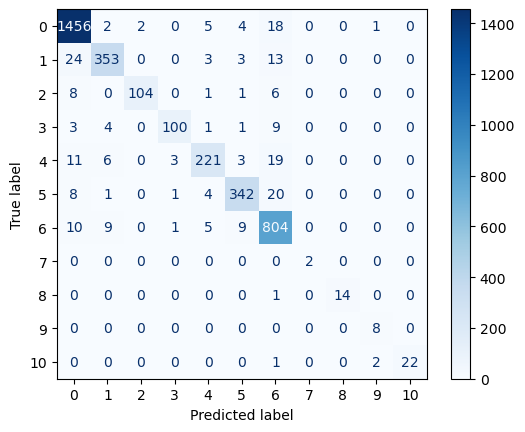

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_solver.classes_)
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.show()

In [ ]:
# The results show overfitting between the train and test split. As these results show the patients with cancer, we want the model to be as accurate as possible. But more importantly, we do not want the model to give false negatives.

In [55]:
# I will test the rate at which the model tests the false negative
# Adding the numbers in the True label column that are not also in the predicted label and dividing it by the sum of the True label
false_values = {
    0 : (2+2+5+4+18+1)/(1456+2+2+5+4+18+1),
    1 : (24+3+3+13)/(353+24+3+3+13),
    2 : (8+1+1+6)/(104+8+1+1+6),
    3 : (3+4+1+1+9)/(100+3+4+1+1+9),
    4 : (11+6+3+3+19)/(221+11+6+3+3+19),
    5 : (8+1+1+4+20)/(342+8+1+1+4+20),
    6 : (10+9+1+5+9)/(804+10+9+1+5+9),
    7 : (0)/(2+0),
    8 : (1)/(14+1),
    9 : (0)/(8+0),
    10 : (1+2)/(22+1+2)
}

In [57]:
for i in range(11):
    print(f"false_{i} =", false_values[i])

false_0 = 0.021505376344086023
false_1 = 0.10858585858585859
false_2 = 0.13333333333333333
false_3 = 0.15254237288135594
false_4 = 0.1596958174904943
false_5 = 0.09042553191489362
false_6 = 0.0405727923627685
false_7 = 0.0
false_8 = 0.06666666666666667
false_9 = 0.0
false_10 = 0.12
